In [1]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from datetime import datetime
import statistics

In [2]:
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"

# import data
count = 0
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [3]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()

df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 25000) & (df1['usd_pledged'] > 2500)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 25000)& (df1['usd_pledged'] > 2500)]
df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [4]:
# first sort by category id, then sort by date
df1.sort_values(['deadline'], ascending = True, inplace = True)
df1_success.sort_values(['deadline'], ascending = True, inplace = True)
df1_fail.sort_values(['deadline'], ascending = True, inplace = True)

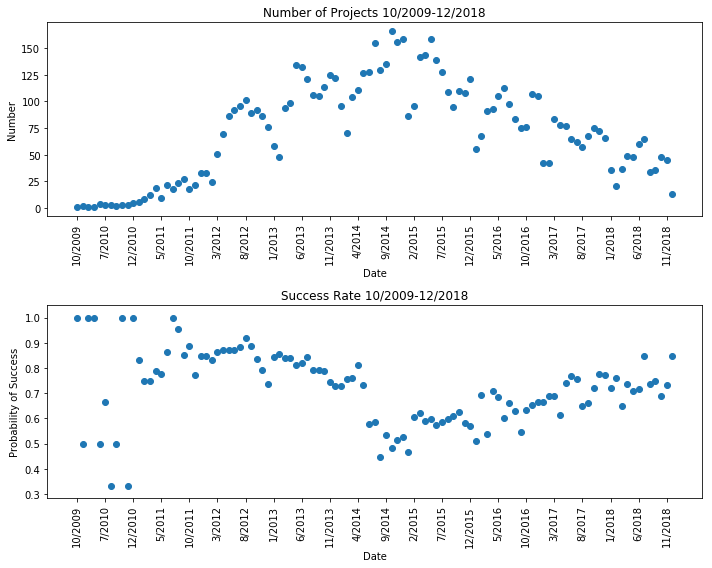

In [76]:
path3 = "../Desktop/cleaned_kickstarter_plots/"

df2 = df1.copy()
# convert date to month/year format
df2['Month/Year'] = df2['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

# sort by date
df3 = df2.groupby(['Month/Year']).size().to_dict()
# holds all projects
ordered_df3 = sorted(df3.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)


# PLOT NUMBER OF PROJECTS
fig = plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.scatter(*zip(*ordered_df3))
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation='vertical') # plot every 5 months
plt.xlabel('Date')
plt.ylabel('Number')
plt.title('Number of Projects 10/2009-12/2018')


# PLOT SUCCESS RATE

df2_success = df1_success.copy()
df2_success['Month/Year'] = df2_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

df3_success = df2_success.groupby(['Month/Year']).size().to_dict()
# holds all successful projects
ordered_df3_success = sorted(df3_success.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

ordered_df3_success_rate = []
# number of success per month / number of projects per month
for i in range(len(ordered_df3_success)):
    lst = list(ordered_df3_success[i])
    lst[1] = ordered_df3_success[i][1] / ordered_df3[i][1]
    ordered_df3_success_rate.append(tuple(lst))

plt.subplot(2, 1, 2)
plt.scatter(*zip(*ordered_df3_success_rate))
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Probability of Success')
plt.title('Success Rate 10/2009-12/2018')

plt.tight_layout()

plt.savefig(path3 + '/Monthy_project_number_vs_success.png')

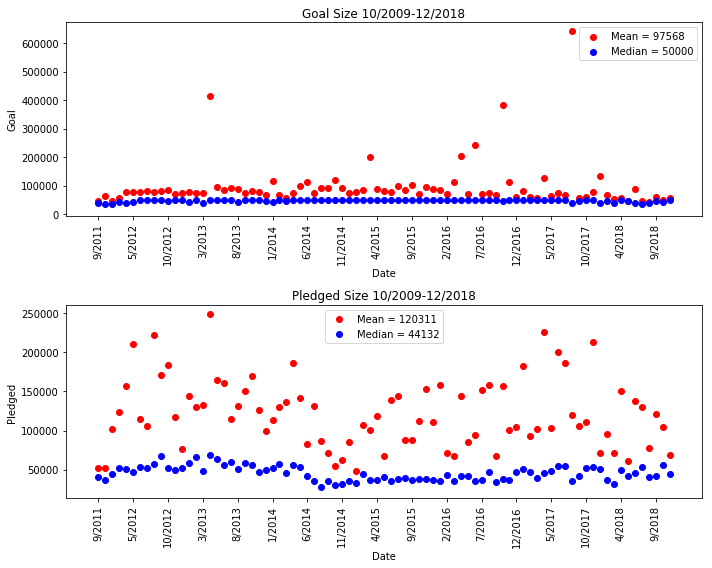

In [77]:
df4 = df1.copy()
df4['Month/Year'] = df4['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

# dictionary of month/Year as key and goal size as value
new_dict = dict()
for i in df4['Month/Year']:
    temp = df4.loc[df4['Month/Year'] == i]
    new_dict[i] = temp['goal']
    
avg_dict = {} # average goal size
median_dict = {} # median goal size
for k,v in new_dict.items():
    avg = sum(v)/ len(v)
    if len(v) > 25: # significant enough number of projects
        avg_dict[k] = sum(v)/ len(v)
        median_dict[k] = statistics.median(v)
    
ordered_df4_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

# PLOT GOAL SIZE

fig = plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.scatter(*zip(*ordered_df4_1), color = 'red')
plt.scatter(*zip(*ordered_df4_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical') 
plt.xlabel('Date')
plt.ylabel('Goal')
plt.legend(['Mean = ' + str(round(sum(df4['goal']) / len(df4['goal']))), 
            'Median = ' + str(round(statistics.median(df4['goal'])))])
plt.title('Goal Size 10/2009-12/2018')


# PLOT PLEDGED SIZE

df5 = df1.copy()
df5['Month/Year'] = df5['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))

# dictionary of month/Year as key and pledged size as value
new_dict1 = dict()
for i in df5['Month/Year']:
    temp = df5.loc[df5['Month/Year'] == i]
    new_dict1[i] = temp['usd_pledged']
    
avg_dict1 = {}
median_dict1 = {}
for k,v in new_dict1.items():
    avg = sum(v)/ len(v)
    if len(v) > 25:
        avg_dict1[k] = sum(v)/ len(v)
        median_dict1[k] = statistics.median(v)
    
ordered_df5_1 = sorted(avg_dict1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df5_2 = sorted(median_dict1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.subplot(2, 1, 2)
plt.scatter(*zip(*ordered_df5_1), color = 'red')
plt.scatter(*zip(*ordered_df5_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Pledged')
plt.legend(['Mean = ' + str(round(sum(df5['usd_pledged']) / len(df5['usd_pledged']))), 
            'Median = ' + str(round(statistics.median(df5['usd_pledged'])))])
plt.title('Pledged Size 10/2009-12/2018')

plt.tight_layout()

plt.savefig(path3 + 'Monthy_goal_size_vs_pledged_size.png')


In [64]:
print('Average goal size: ')
print(sum(df4['goal']) / len(df4['goal']))
# $97,567
print('Median goal size: ')
print(statistics.median(df4['goal']))
# $50,000
print('Average pledged size: ')
print(sum(df5['usd_pledged']) / len(df5['usd_pledged']))
# $120,310
print('Median pledged size: ')
print(statistics.median(df5['usd_pledged']))
# $44,131

Average goal size: 
97567.92937710437
Median goal size: 
50000.0
Average pledged size: 
120310.50138306126
Median pledged size: 
44131.58


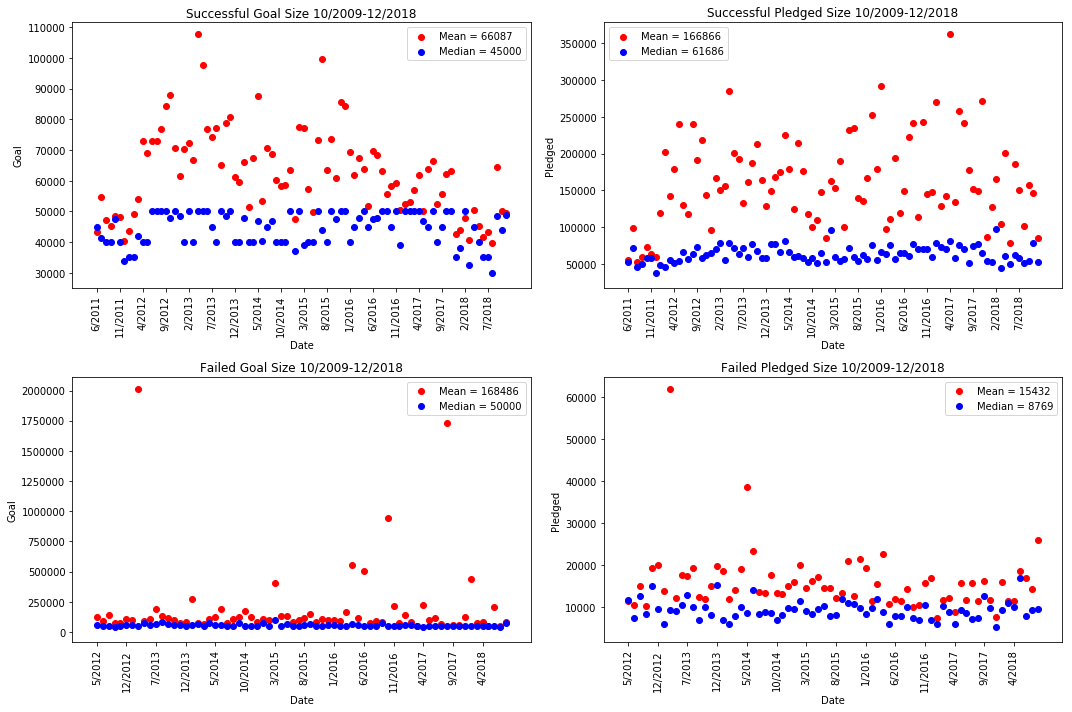

In [78]:
# same as previous approach except using dataframe of only successful or failed projects

df4_success = df1_success.copy()
df4_success['Month/Year'] = df4_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict = dict()
for i in df4_success['Month/Year']:
    temp = df4_success.loc[df4_success['Month/Year'] == i]
    new_dict[i] = temp['goal']
    
avg_dict = {}
median_dict = {}
for k,v in new_dict.items():
    avg = sum(v)/ len(v)
    if len(v) > 15: # significant enough number of projects
        avg_dict[k] = sum(v)/ len(v)
        median_dict[k] = statistics.median(v)
    
ordered_df4_success_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_success_2 = sorted(median_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

# PLOT SUCCESSFUL GOAL SIZE

fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)

plt.scatter(*zip(*ordered_df4_success_1), color = 'red')
plt.scatter(*zip(*ordered_df4_success_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical') 
plt.xlabel('Date')
plt.ylabel('Goal')
plt.legend(['Mean = ' + str(round(sum(df4_success['goal']) / len(df4_success['goal']))), 
            'Median = ' + str(round(statistics.median(df4_success['goal'])))])
plt.title('Successful Goal Size 10/2009-12/2018')

# PLOT SUCCESSFUL PLEDGED SIZE
plt.subplot(2, 2, 2)

df5_success = df1_success.copy()
df5_success['Month/Year'] = df5_success['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict1 = dict()
for i in df5_success['Month/Year']:
    temp = df5_success.loc[df5_success['Month/Year'] == i]
    new_dict1[i] = temp['usd_pledged']
    
avg_dict1 = {}
median_dict1 = {}
for k,v in new_dict1.items():
    avg = sum(v)/ len(v)
    if len(v) > 15: # significant enough number of projects
        avg_dict1[k] = sum(v)/ len(v)
        median_dict1[k] = statistics.median(v)
    
ordered_df5_success_1 = sorted(avg_dict1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df5_success_2 = sorted(median_dict1.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df5_success_1), color = 'red')
plt.scatter(*zip(*ordered_df5_success_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Pledged')
plt.legend(['Mean = ' + str(round(sum(df5_success['usd_pledged']) / len(df5_success['usd_pledged']))), 
            'Median = ' + str(round(statistics.median(df5_success['usd_pledged'])))])
plt.title('Successful Pledged Size 10/2009-12/2018')

# PLOT FAILED GOAL SIZE
plt.subplot(2, 2, 3)

df4_fail = df1_fail.copy()
df4_fail['Month/Year'] = df4_fail['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict2 = dict()
for i in df4_fail['Month/Year']:
    temp = df4_fail.loc[df4_fail['Month/Year'] == i]
    new_dict2[i] = temp['goal']
    
avg_dict2 = {}
median_dict2 = {}
for k,v in new_dict2.items():
    avg = sum(v)/ len(v)
    if len(v) > 10: # significant enough number of projects
        avg_dict2[k] = sum(v)/ len(v)
        median_dict2[k] = statistics.median(v)
    
ordered_df4_fail_1 = sorted(avg_dict2.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df4_fail_2 = sorted(median_dict2.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df4_fail_1), color = 'red')
plt.scatter(*zip(*ordered_df4_fail_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Goal')
plt.legend(['Mean = ' + str(round(sum(df4_fail['goal']) / len(df4_fail['goal']))), 
            'Median = ' + str(round(statistics.median(df4_fail['goal'])))])
plt.title('Failed Goal Size 10/2009-12/2018')

# PLOT FAILED PLEDGED SIZE

plt.subplot(2, 2, 4)
df5_fail = df1_fail.copy()
df5_fail['Month/Year'] = df5_fail['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
new_dict3 = dict()
for i in df5_fail['Month/Year']:
    temp = df5_fail.loc[df5_fail['Month/Year'] == i]
    new_dict3[i] = temp['usd_pledged']
    
avg_dict3 = {}
median_dict3 = {}
for k,v in new_dict3.items():
    avg = sum(v)/ len(v)
    if len(v) > 10: # significant enough number of projects
        avg_dict3[k] = sum(v)/ len(v)
        median_dict3[k] = statistics.median(v)
    
ordered_df5_fail_1 = sorted(avg_dict3.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
ordered_df5_fail_2 = sorted(median_dict3.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)

plt.scatter(*zip(*ordered_df5_fail_1), color = 'red')
plt.scatter(*zip(*ordered_df5_fail_2), color = 'blue')
locs, labs = plt.xticks() 
plt.xticks(locs[0::5], rotation = 'vertical')
plt.xlabel('Date')
plt.ylabel('Pledged')
plt.legend(['Mean = ' + str(round(sum(df5_fail['usd_pledged']) / len(df5_fail['usd_pledged']))), 
            'Median = ' + str(round(statistics.median(df5_fail['usd_pledged'])))])
plt.title('Failed Pledged Size 10/2009-12/2018')

plt.tight_layout()

plt.savefig(path3 + 'Monthy_goal_size_vs_pledged_size_successful_vs_fail.png')

In [68]:
print('Average successful goal size: ')
print(sum(df4_success['goal']) / len(df4_success['goal']))
# $66,087
print('Median successful goal size: ')
print(statistics.median(df4_success['goal']))
# $45,000

print('Average successful pledged size: ')
print(sum(df5_success['usd_pledged']) / len(df5_success['usd_pledged']))
# $166,866
print('Median successful pledged size: ')
print(statistics.median(df5_success['usd_pledged']))
# $61,685

print('Average failed goal size: ')
print(sum(df4_fail['goal']) / len(df4_fail['goal']))
# $168,486
print('Median failed goal size: ')
print(statistics.median(df4_fail['goal']))
# $50,000

print('Average failed pledged size: ')
print(sum(df5_fail['usd_pledged']) / len(df5_fail['usd_pledged']))
# $15,432
print('Median failed pledged size: ')
print(statistics.median(df5_fail['usd_pledged']))
# $8769

Average successful goal size: 
66087.00722700074
Median successful goal size: 
45000.0
Average successful pledged size: 
166866.48235415085
Median successful pledged size: 
61685.5
Average failed goal size: 
168486.19882055602
Median failed goal size: 
50000.0
Average failed pledged size: 
15432.074157540012
Median failed pledged size: 
8769.0


In [ ]:
# additional categories

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


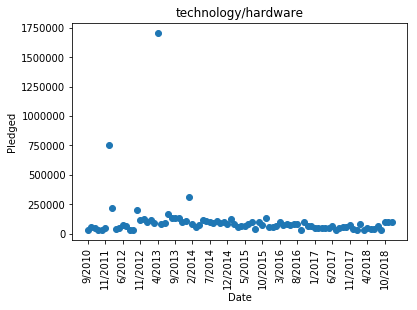

Average goal amount: technology/hardware
146741.88299531981


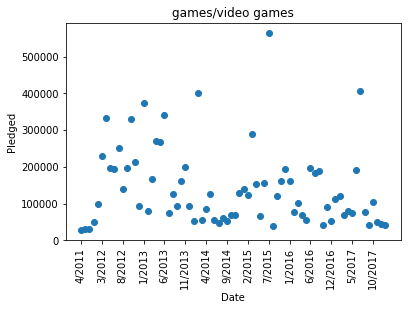

Average goal amount: games/video games
145506.78899082568


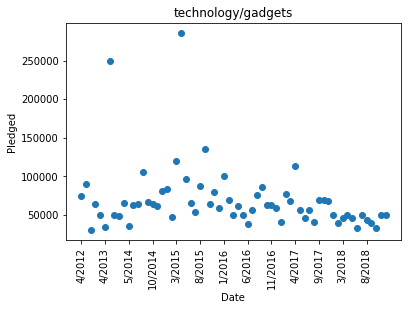

Average goal amount: technology/gadgets
72445.87320574162


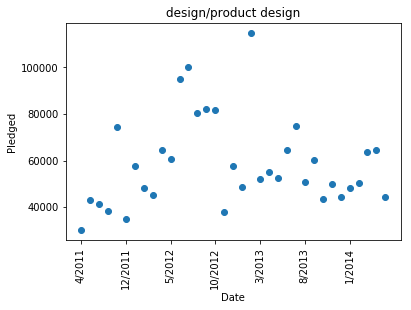

Average goal amount: design/product design
61432.180428134554


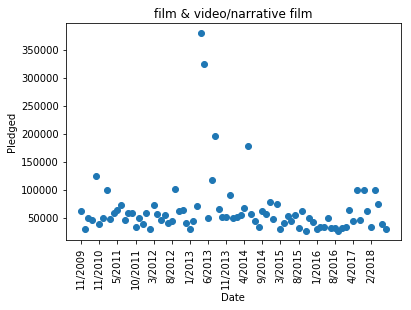

Average goal amount: film & video/narrative film
80731.11151079136


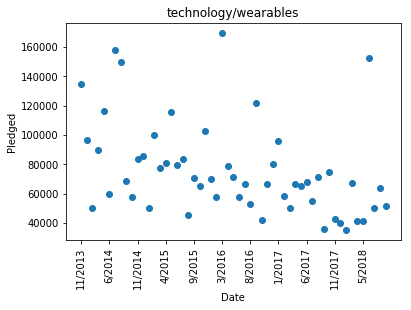

Average goal amount: technology/wearables
78250.90196078431


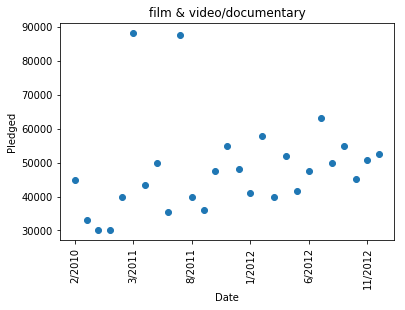

Average goal amount: film & video/documentary
49477.01992031872


In [79]:
category_freq = df1['category_name'].value_counts().to_dict()

df4_1 = df1.copy()

for i in category_freq.keys():
    temp = df4_1.loc[df4_1['category_name'] == i]
    if len(temp) >= 220: # at least 4 projects a month
        temp['Month/Year'] = temp['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
        new_dict = dict()
        for j in temp['Month/Year']:
            temp1 = temp.loc[temp['Month/Year'] == j]
            new_dict[j] = temp1['goal']

        avg_dict = {}
        for k,v in new_dict.items():
            avg_dict[k] = sum(v)/ len(v)

        ordered_df4_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
        
        plt.scatter(*zip(*ordered_df4_1))
        locs, labs = plt.xticks() 
        plt.xticks(locs[0::5], rotation = 'vertical') 
        plt.xlabel('Date')
        plt.ylabel('Pledged')
        plt.title(i)
        plt.show()
    
        print('Average goal amount: ' + i)
        print(sum(temp['goal']) / len(temp['goal']))

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


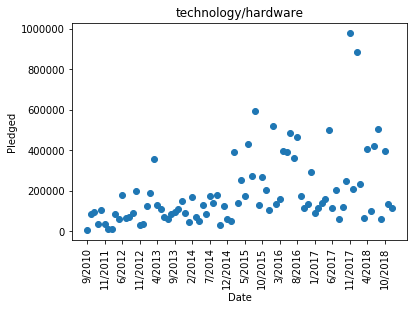

Average pledge amount: 
160687.5165054603


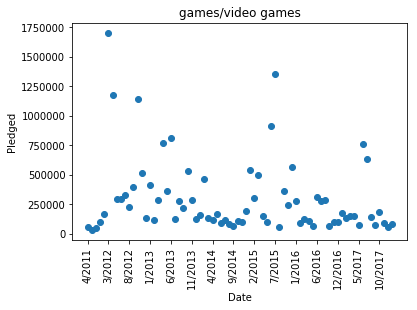

Average pledge amount: 
307489.87903669727


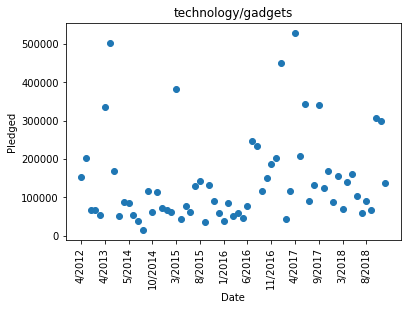

Average pledge amount: 
132838.11447368423


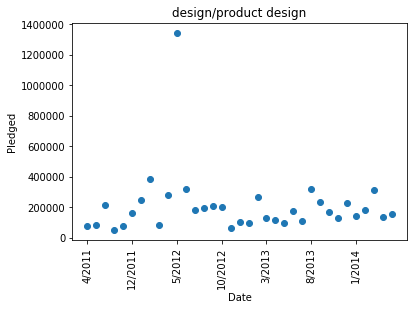

Average pledge amount: 
207949.63886850147


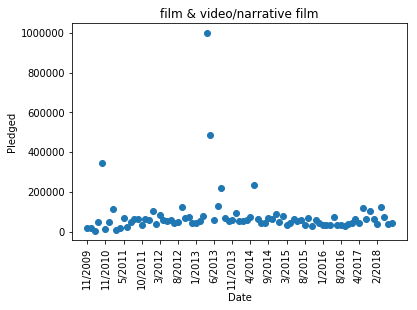

Average pledge amount: 
104587.196618705


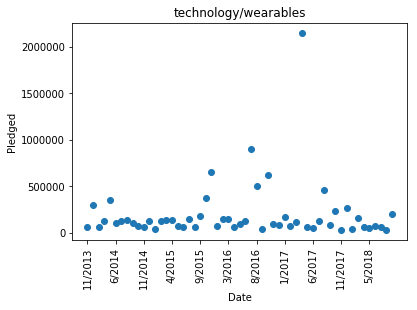

Average pledge amount: 
186993.91603921572


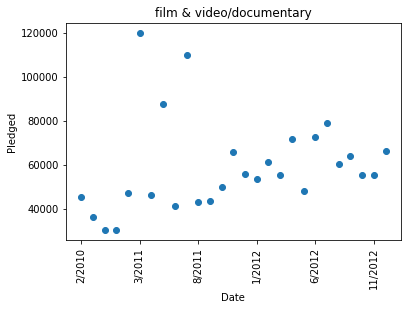

Average pledge amount: 
61764.56023904384


In [80]:
category_freq = df1['category_name'].value_counts().to_dict()

df5_1 = df1.copy()

for i in category_freq.keys():
    temp = df5_1.loc[df5_1['category_name'] == i]
    if len(temp) >= 220:
        temp['Month/Year'] = temp['deadline'].apply(lambda x: "%d/%d" % (x.month, x.year))
        new_dict = dict()
        for j in temp['Month/Year']:
            temp1 = temp.loc[temp['Month/Year'] == j]
            new_dict[j] = temp1['usd_pledged']

        avg_dict = {}
        for k,v in new_dict.items():
            avg_dict[k] = sum(v)/ len(v)

        ordered_df5_1 = sorted(avg_dict.items(), key = lambda x:datetime.strptime(x[0], '%m/%Y'), reverse=False)
        
        plt.scatter(*zip(*ordered_df5_1))
        locs, labs = plt.xticks() 
        plt.xticks(locs[0::5], rotation = 'vertical') 
        plt.xlabel('Date')
        plt.ylabel('Pledged')
        plt.title(i)
        plt.show()
        
        print('Average pledge amount: ')
        print(sum(temp['usd_pledged']) / len(temp['usd_pledged']))